In [3]:
# re-recreate previous OHBM plots but for scatter plot, do slope vs variance
# based odd of 14_create_OHBM_figure_individual

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import pickle
import seaborn as sns
import gc
import psutil
import math
import scipy.stats as stats
from matplotlib.patches import Patch
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
from nilearn import masking, image
from nilearn import datasets
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting.find_cuts import find_cut_slices
import nibabel as nib


# Import shared utilities and configuration
# need to do it this way because in a sub-directory (later turn config and utils into part of a package)
from utils import (
    TASKS, CONTRASTS, SUBJECTS, SESSIONS, ENCOUNTERS,
    build_first_level_contrast_map_path, is_valid_contrast_map, clean_z_map_data,
    convert_to_regular_dict, create_smor_atlas,load_smor_atlas, load_schaefer_atlas, cleanup_memory
)
from config import BASE_DIR, OUTPUT_DIRS

In [2]:
# smorgasbord stuff
SMORG_PARCELLATED_DIR = OUTPUT_DIRS["smor"]
smor_files = {'mean':f'discovery_parcel_indiv_mean_updated'}
smor_date_updated = '0111'
indices = [1,2,3]
# get smorgasbord atlas
smorgasbord_atlas = load_smor_atlas()
SMORG_IMG = smorgasbord_atlas.maps
SMORG_DATA = SMORG_IMG.get_fdata()

req_atlas = "smor"
main_dir = SMORG_PARCELLATED_DIR
main_files = smor_files
date_updated = smor_date_updated
atlas_obj = smorgasbord_atlas
atlas_img = SMORG_IMG
atlas_data = SMORG_DATA

Loading Smorgasbord atlas...
Atlas loaded with 429 regions
Atlas shape: (193, 229, 193)


In [3]:
# file loading
file_type = "default" # can change to "default" to make this code use betas
output_ending = "_betas"
if (file_type == "z"):
    output_ending = "_z_scored"
        
# Load mean parcel data from multiple files
mean_filename = f"{main_dir}/{main_files['mean']}_{date_updated}"

In [4]:
# load the individual trajectories and data
indiv_dict_file = f'{mean_filename}{output_ending}_indiv_slopes.pkl'
with open(indiv_dict_file, 'rb') as f:
    indiv_parcel_traj_results = pickle.load(f)
    
print(f"\nTotal subjects loaded: {len(indiv_parcel_traj_results)}")
print(f"Atlas: {req_atlas} ({len(atlas_obj.labels)} regions)")


Total subjects loaded: 5
Atlas: smor (429 regions)


In [5]:
# verify numbers for each
for subj in SUBJECTS:
    count = 0
    
    for task in indiv_parcel_traj_results[subj].keys():
        for contrast in indiv_parcel_traj_results[subj][task].keys():
            count += 1
    print(f"for {subj} there are {count} specific task/contrast combos loaded")

for sub-s03 there are 40 specific task/contrast combos loaded
for sub-s10 there are 40 specific task/contrast combos loaded
for sub-s19 there are 40 specific task/contrast combos loaded
for sub-s29 there are 40 specific task/contrast combos loaded
for sub-s43 there are 40 specific task/contrast combos loaded


In [6]:
# Collate the data for the scatterplot
indiv_activations = defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(list)
            )
        )
)

for subj in indiv_parcel_traj_results.keys():
    for task in indiv_parcel_traj_results[subj].keys():
        for contrast in indiv_parcel_traj_results[subj][task].keys():
            for parcel in indiv_parcel_traj_results[subj][task][contrast].keys():
                indiv_activations[subj][task][contrast]["parcel_names"].append(parcel)
                indiv_activations[subj][task][contrast]["centered_intercept"].append(indiv_parcel_traj_results[subj][task][contrast][parcel]["beta_intercept"])
                indiv_activations[subj][task][contrast]["slope"].append(indiv_parcel_traj_results[subj][task][contrast][parcel]["beta_slope"])
                indiv_activations[subj][task][contrast]["slope_std_error"].append(indiv_parcel_traj_results[subj][task][contrast][parcel]["std_error"])
                indiv_activations[subj][task][contrast]["residual_variance"].append(indiv_parcel_traj_results[subj][task][contrast][parcel]["residual_variance"])
                indiv_activations[subj][task][contrast]["residual_std"].append(indiv_parcel_traj_results[subj][task][contrast][parcel]["residual_std"])
                indiv_activations[subj][task][contrast]["trajectory_std"].append(indiv_parcel_traj_results[subj][task][contrast][parcel]["trajectory_std"])

# Creating indiv plots

In [7]:
tasks_to_plot = {
    "stopSignal": 'stop_failure-go',
    "goNogo": "nogo_success-go",
    "nBack": "twoBack-oneBack",
    "directedForgetting":"neg-con",
    "cuedTS":'task_switch_cue_switch-task_stay_cue_stay',
    "spatialTS": 'task_switch_cue_switch-task_stay_cue_stay',
    "shapeMatching": "main_vars",
    "flanker":"incongruent-congruent",
}

# function which returns the scatterplot of slope vs fixed effects
def get_network_category(parcel_name):
    if 'Vis' in parcel_name:
        return 'Visual'
    elif 'SomMot' in parcel_name:
        return 'Somatomotor'
    elif 'DorsAttn' in parcel_name:
        return 'Dorsal Attention'
    elif 'SalVentAttn' in parcel_name:
        return 'Salience/Ventral Attention'
    elif 'Limbic' in parcel_name:
        return 'Limbic'
    elif 'Cont' in parcel_name:
        return 'Control'
    elif 'Default' in parcel_name:
        return 'Default Mode'
    else:
        return 'Subcortical/Other'

# Create color mapping
network_colors = {
    'Visual': 'blue',
    'Somatomotor': 'green',
    'Dorsal Attention': 'orange',
    'Salience/Ventral Attention': 'purple',
    'Limbic': 'pink',
    'Control': 'red',
    'Default Mode': 'yellow',
    'Subcortical/Other': 'gray'
}

In [19]:
def indiv_plot_comprehensive_summary(subj_id, avg_activations, avg_parcel_traj_results,
                                tasks_to_plot, z_slice=0,
                                x_min=None, x_max=None, y_min=None, y_max=None,
                                threshold=None, save_path="OHBM_plot.png"):
    """
    Create a 8x2 plot showing slopes and slope vs residual variance scatterplot for each task/contrast.
    
    Parameters:
    -----------
    avg_activations : dict
        Dictionary containing activation data for scatterplots
    avg_parcel_traj_results : dict
        Dictionary containing slope and residual variance results
    fixed_avg_parcel_traj_results : dict
        Dictionary containing fixed effects results (not used in current version)
    tasks_to_plot : dict
        Dictionary mapping task names to contrasts
    z_slice : int
        Brain slice coordinate for axial view
    x_min, x_max : float
        Axis limits for slope values (brain map and x-axis of scatterplot)
    y_min, y_max : float
        Axis limits for residual variance (y-axis of scatterplot)
    threshold : float
        Threshold for brain maps
    save_path : str, optional
        Path to save the figure
    
    Returns:
    --------
    fig : matplotlib figure
    """
    n_tasks = len(tasks_to_plot)
    fig = plt.figure(figsize=(14, 5*n_tasks))  # 2 columns, n_tasks rows
    
    # Create a grid: n_tasks rows x 2 columns (slopes brain map, scatterplot)
    gs = fig.add_gridspec(n_tasks, 2, hspace=0.4, wspace=0.3, top=0.91, bottom=0.02, left=0.05, right=0.95)
    
    task_names = list(tasks_to_plot.keys())
    
    for row_idx, task in enumerate(task_names):
        contrast = tasks_to_plot[task]
        
        print(f"Processing {task} - {contrast}...")
        
        # Get atlas labels
        atlas_labels = [label.decode('utf-8') if isinstance(label, bytes) else label 
                       for label in atlas_obj.labels]
        
        # Column 0: Slopes brain map
        parcel_data = avg_parcel_traj_results[task][contrast]
        slope_data = np.zeros_like(atlas_data)
        
        for i, atlas_label in enumerate(atlas_labels):
            if atlas_label in parcel_data:
                slope_value = parcel_data[atlas_label]['beta_slope']
                
                if hasattr(atlas_obj, 'roi_values'):
                    roi_value = atlas_obj.roi_values[i]
                    slope_data[atlas_data == roi_value] = slope_value
                else:
                    slope_data[atlas_data == (i + 1)] = slope_value
        
        slope_img = nib.Nifti1Image(slope_data, atlas_img.affine)
        
        if x_min is not None and x_max is not None:
            vmin_slope, vmax_slope = x_min, x_max
        else:
            nonzero_slopes = slope_data[slope_data != 0]
            vmin_slope, vmax_slope = np.percentile(nonzero_slopes, [2, 98])
        
        abs_max_slope = max(abs(vmin_slope), abs(vmax_slope))
        
        ax_slopes = fig.add_subplot(gs[row_idx, 0])
        plotting.plot_stat_map(slope_img,
                               colorbar=True,
                               cmap='RdBu_r',
                               vmin=-abs_max_slope,
                               vmax=abs_max_slope,
                               symmetric_cbar=True,
                               threshold=threshold,
                               display_mode='z',
                               axes=ax_slopes,
                               cut_coords=[z_slice],
                               draw_cross=False)
        
        # Increase colorbar label size for slopes
        ax_slopes.get_figure().axes[-1].tick_params(labelsize=18)
        
        # Column 1: Slope vs Residual Variance Scatterplot
        ax_scatter = fig.add_subplot(gs[row_idx, 1])
        
        # Get parcel names and network categories
        parcels = list(parcel_data.keys())
        network_categories = [get_network_category(p) for p in parcels]
        
        # Get x (slope) and y (residual variance) values
        x_all = [parcel_data[p]['beta_slope'] for p in parcels]
        y_all = [parcel_data[p]['residual_std'] for p in parcels]
        
        # Plot each network separately for legend
        for network in network_colors.keys():
            mask = [cat == network for cat in network_categories]
            if any(mask):
                x_vals = [x_all[i] for i, m in enumerate(mask) if m]
                y_vals = [y_all[i] for i, m in enumerate(mask) if m]
                
                ax_scatter.scatter(x_vals, y_vals, 
                          c=network_colors[network], 
                          label=network, 
                          alpha=0.45, 
                          s=20)
        
        ax_scatter.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax_scatter.set_xlabel("Slope (Change per Encounter)", fontsize=22)
        ax_scatter.set_ylabel("Residual SD", fontsize=22)
        
        # Increase tick label sizes for scatterplot
        ax_scatter.tick_params(axis='both', which='major', labelsize=18)
        
        # Increase legend font size
        ax_scatter.legend(fontsize=16, loc='center left', bbox_to_anchor=(1.02, 0.5))
    
        # Set axis limits
        if x_min is not None and x_max is not None:
            ax_scatter.set_xlim(x_min, x_max)
        if y_min is not None and y_max is not None:
            ax_scatter.set_ylim(y_min, y_max)
        
        # Add task/contrast label - anchored to the middle of the row
        bbox = ax_slopes.get_position()
        label_y = bbox.y1 + 0.01  # Slightly above the top of the subplot
        
        fig.text(0.5, label_y, f"{task} | {contrast}", 
                ha='center', va='bottom', fontsize=22, fontweight='bold',
                transform=fig.transFigure)
    
    # Add main title at the very top
    fig.suptitle(f'{subj_id}: Slopes and variability (z={z_slice})', 
                fontsize=26, fontweight='bold', y=0.98)
    
    # Add column headers - between title and plots
    fig.text(0.28, 0.94, 'Slope of Change', ha='center', fontsize=22, fontweight='bold')
    fig.text(0.72, 0.94, 'Slope vs Residual Variability', ha='center', fontsize=22, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    return fig

In [20]:
# Calculate global limits across ALL tasks and contrasts in tasks_to_plot
all_x_vals = []
all_y_vals = []
x_min = 0
x_max = 0
y_min = 0
y_max = 0

# Swap x and y so slope is always on X-axis
for subj in indiv_activations.keys():
    for task in indiv_activations[subj].keys():
        for contrast in indiv_activations[subj][task].keys():
            if (task not in tasks_to_plot):
                continue
            elif (contrast != tasks_to_plot[task]):
                continue
            print(f"looking at {task}|{contrast}")
                
            x_vals = indiv_activations[subj][task][contrast]["slope"]
            y_vals = indiv_activations[subj][task][contrast]["residual_std"]
            
            if len(x_vals) > 0 and len(y_vals) > 0:
                all_x_vals.extend(x_vals)
                all_y_vals.extend(y_vals)

# Now x = slope, y = residual_std
x_min, x_max = np.min(all_x_vals), np.max(all_x_vals)  # slope limits
y_min, y_max = np.percentile(all_y_vals, [1, 99])     # residual_std limits

# Add padding
x_padding = 0.1
y_padding = 0.1
x_min -= x_padding
x_max += x_padding
y_min -= y_padding
y_max += y_padding

print(f"X-axis limits (Slopes): [{x_min:.3f}, {x_max:.3f}]")
print(f"Y-axis limits (Residual Std): [{y_min:.3f}, {y_max:.3f}]")
print(f"Number of data points: {len(all_x_vals)}")

looking at nBack|twoBack-oneBack
looking at flanker|incongruent-congruent
looking at directedForgetting|neg-con
looking at goNogo|nogo_success-go
looking at shapeMatching|main_vars
looking at stopSignal|stop_failure-go
looking at cuedTS|task_switch_cue_switch-task_stay_cue_stay
looking at spatialTS|task_switch_cue_switch-task_stay_cue_stay
looking at nBack|twoBack-oneBack
looking at flanker|incongruent-congruent
looking at directedForgetting|neg-con
looking at goNogo|nogo_success-go
looking at shapeMatching|main_vars
looking at stopSignal|stop_failure-go
looking at cuedTS|task_switch_cue_switch-task_stay_cue_stay
looking at spatialTS|task_switch_cue_switch-task_stay_cue_stay
looking at nBack|twoBack-oneBack
looking at flanker|incongruent-congruent
looking at directedForgetting|neg-con
looking at goNogo|nogo_success-go
looking at shapeMatching|main_vars
looking at stopSignal|stop_failure-go
looking at cuedTS|task_switch_cue_switch-task_stay_cue_stay
looking at spatialTS|task_switch_cue_

Processing stopSignal - stop_failure-go...
Processing goNogo - nogo_success-go...
Processing nBack - twoBack-oneBack...
Processing directedForgetting - neg-con...
Processing cuedTS - task_switch_cue_switch-task_stay_cue_stay...
Processing spatialTS - task_switch_cue_switch-task_stay_cue_stay...
Processing shapeMatching - main_vars...
Processing flanker - incongruent-congruent...
Figure saved to sub-s03_slopes_plot_0113.png
Processing stopSignal - stop_failure-go...
Processing goNogo - nogo_success-go...
Processing nBack - twoBack-oneBack...
Processing directedForgetting - neg-con...
Processing cuedTS - task_switch_cue_switch-task_stay_cue_stay...
Processing spatialTS - task_switch_cue_switch-task_stay_cue_stay...
Processing shapeMatching - main_vars...
Processing flanker - incongruent-congruent...
Figure saved to sub-s10_slopes_plot_0113.png
Processing stopSignal - stop_failure-go...
Processing goNogo - nogo_success-go...
Processing nBack - twoBack-oneBack...
Processing directedForgett

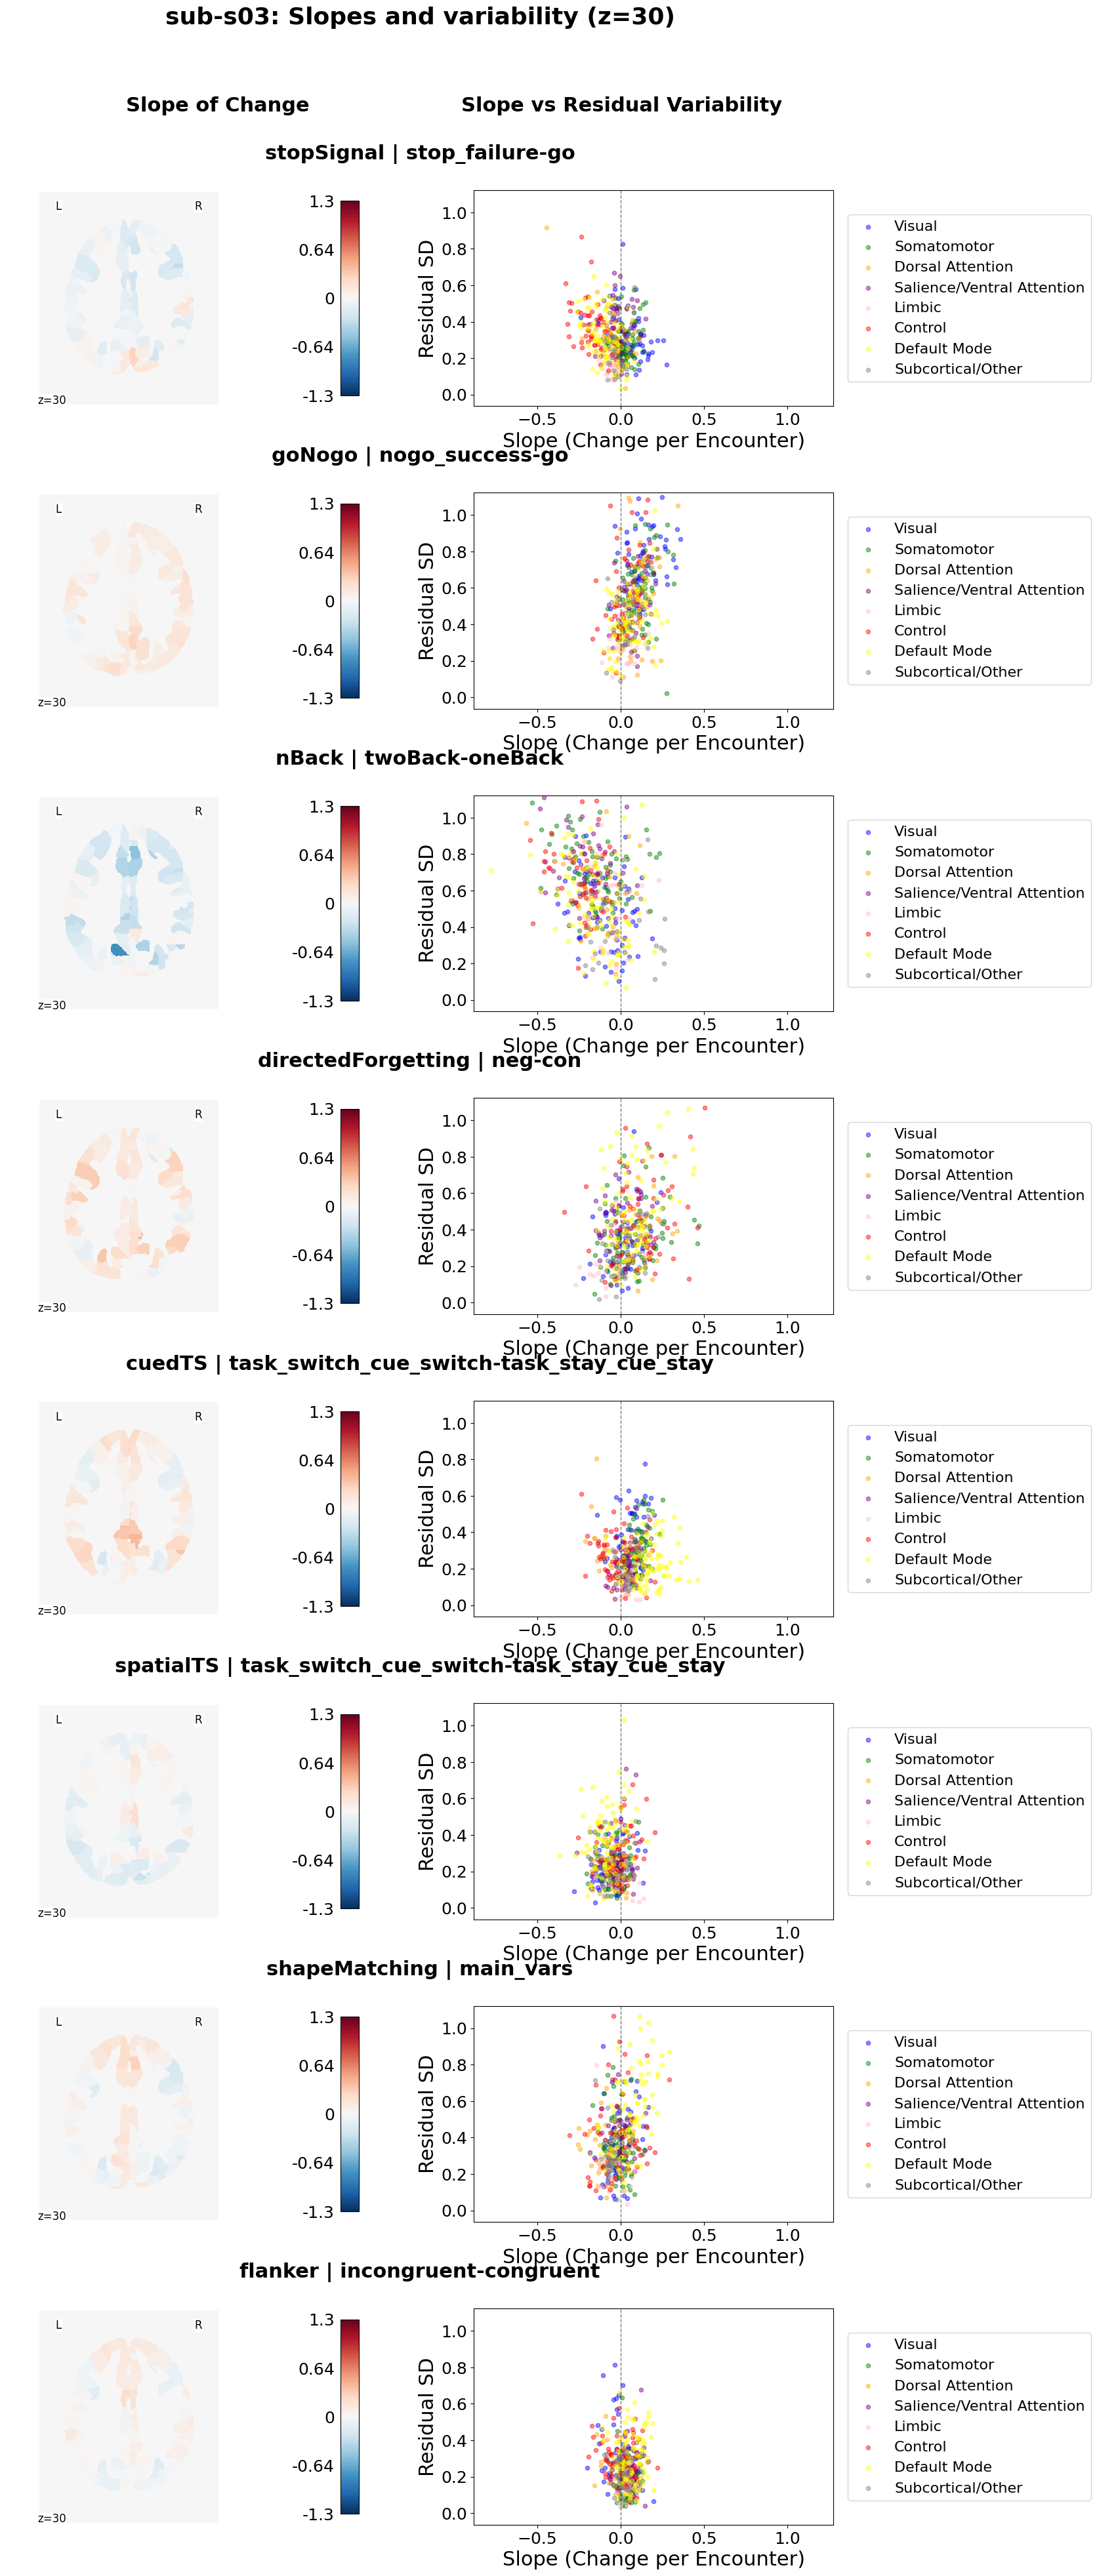

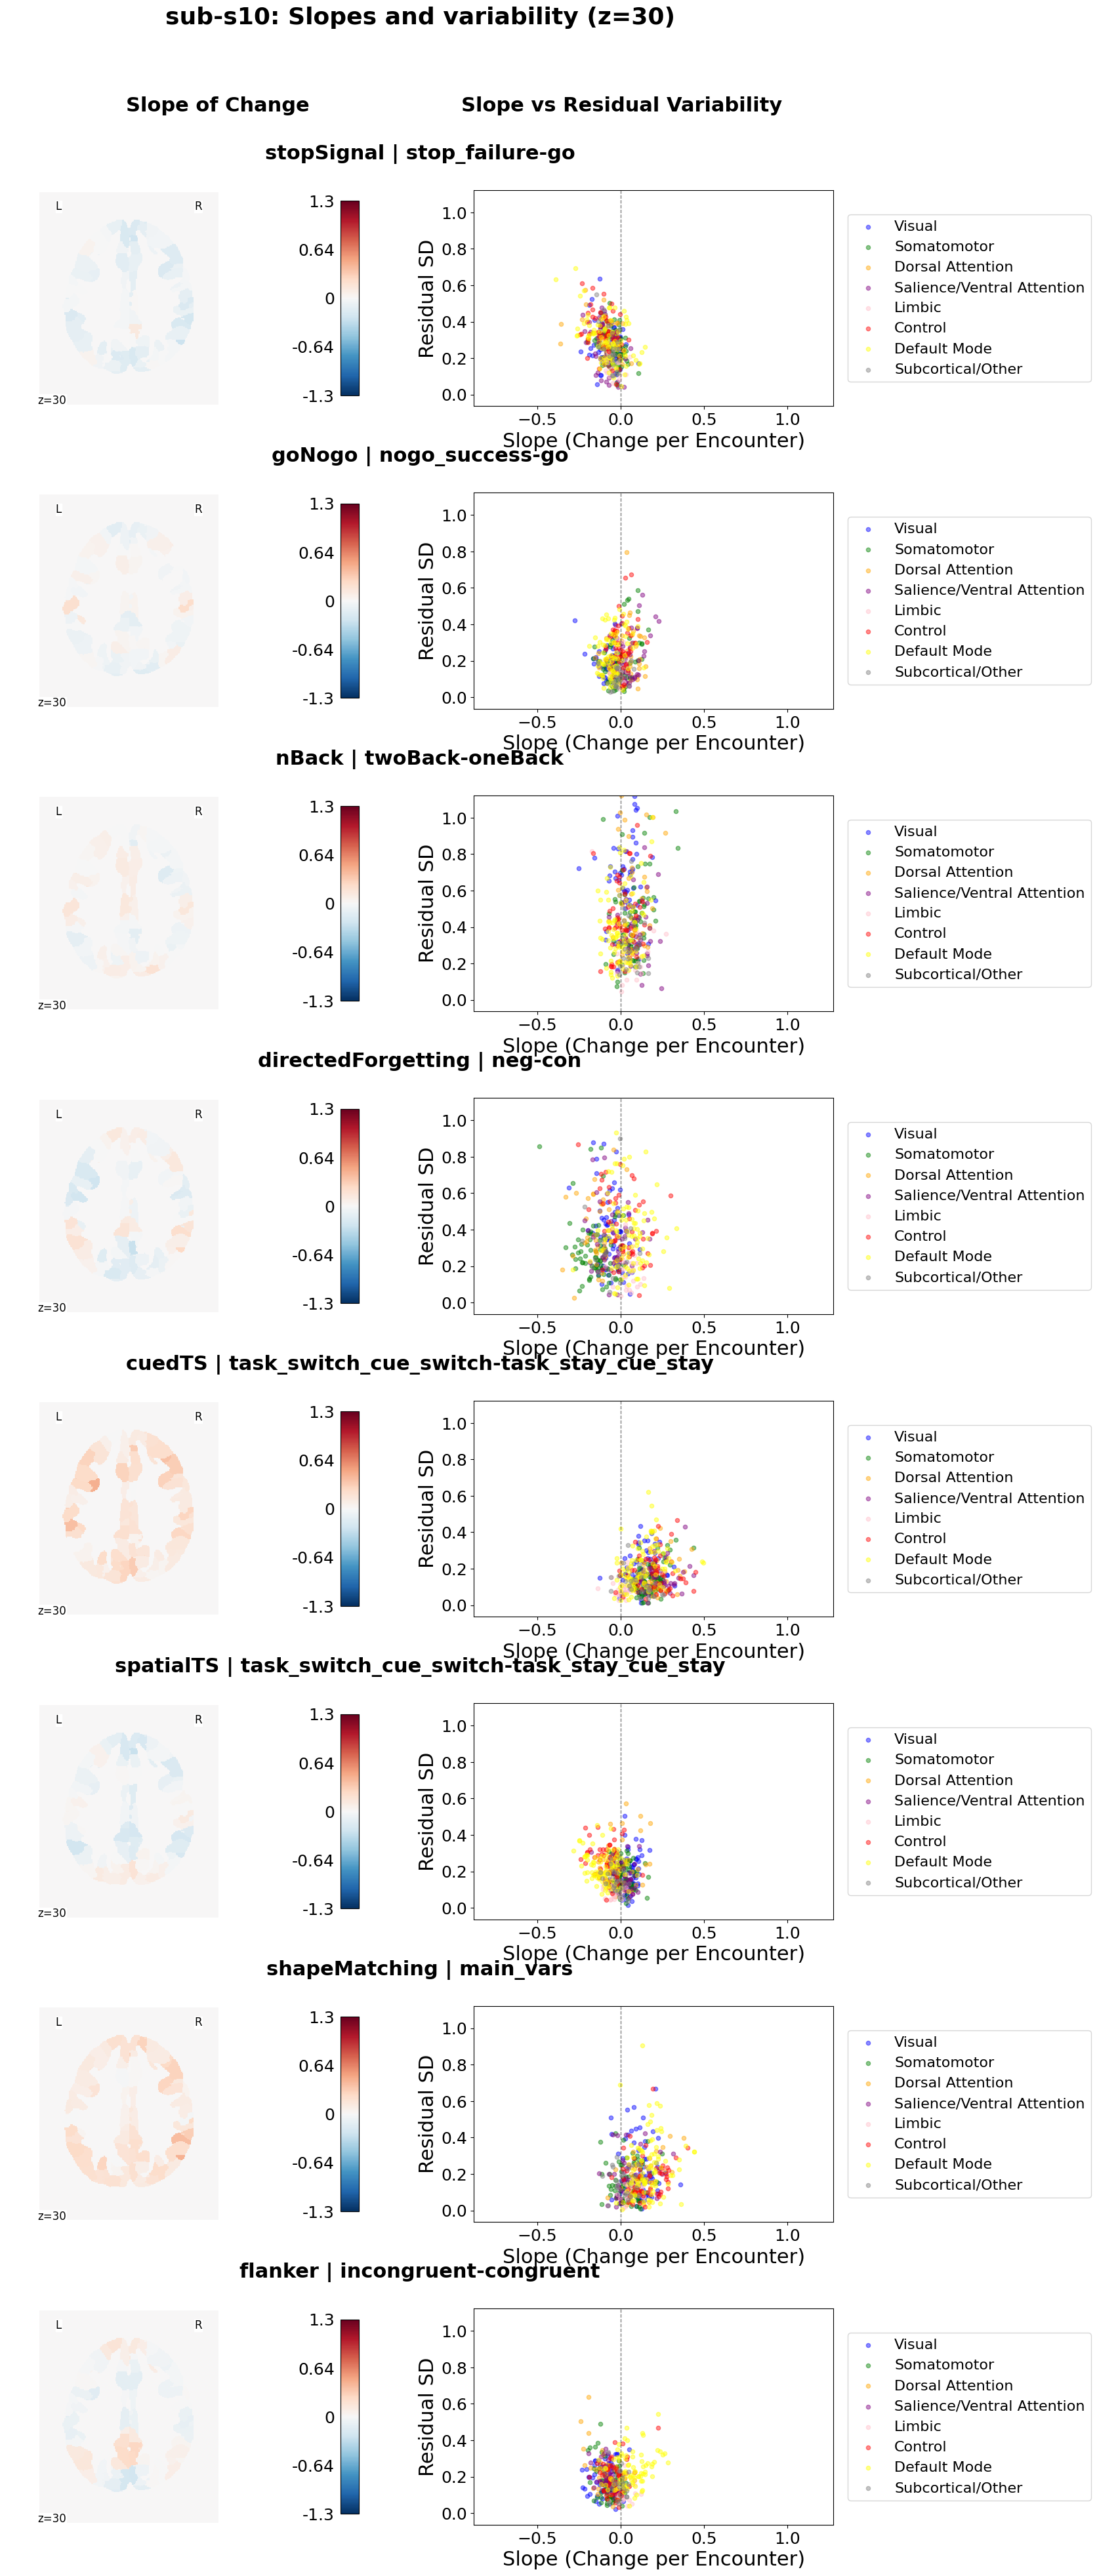

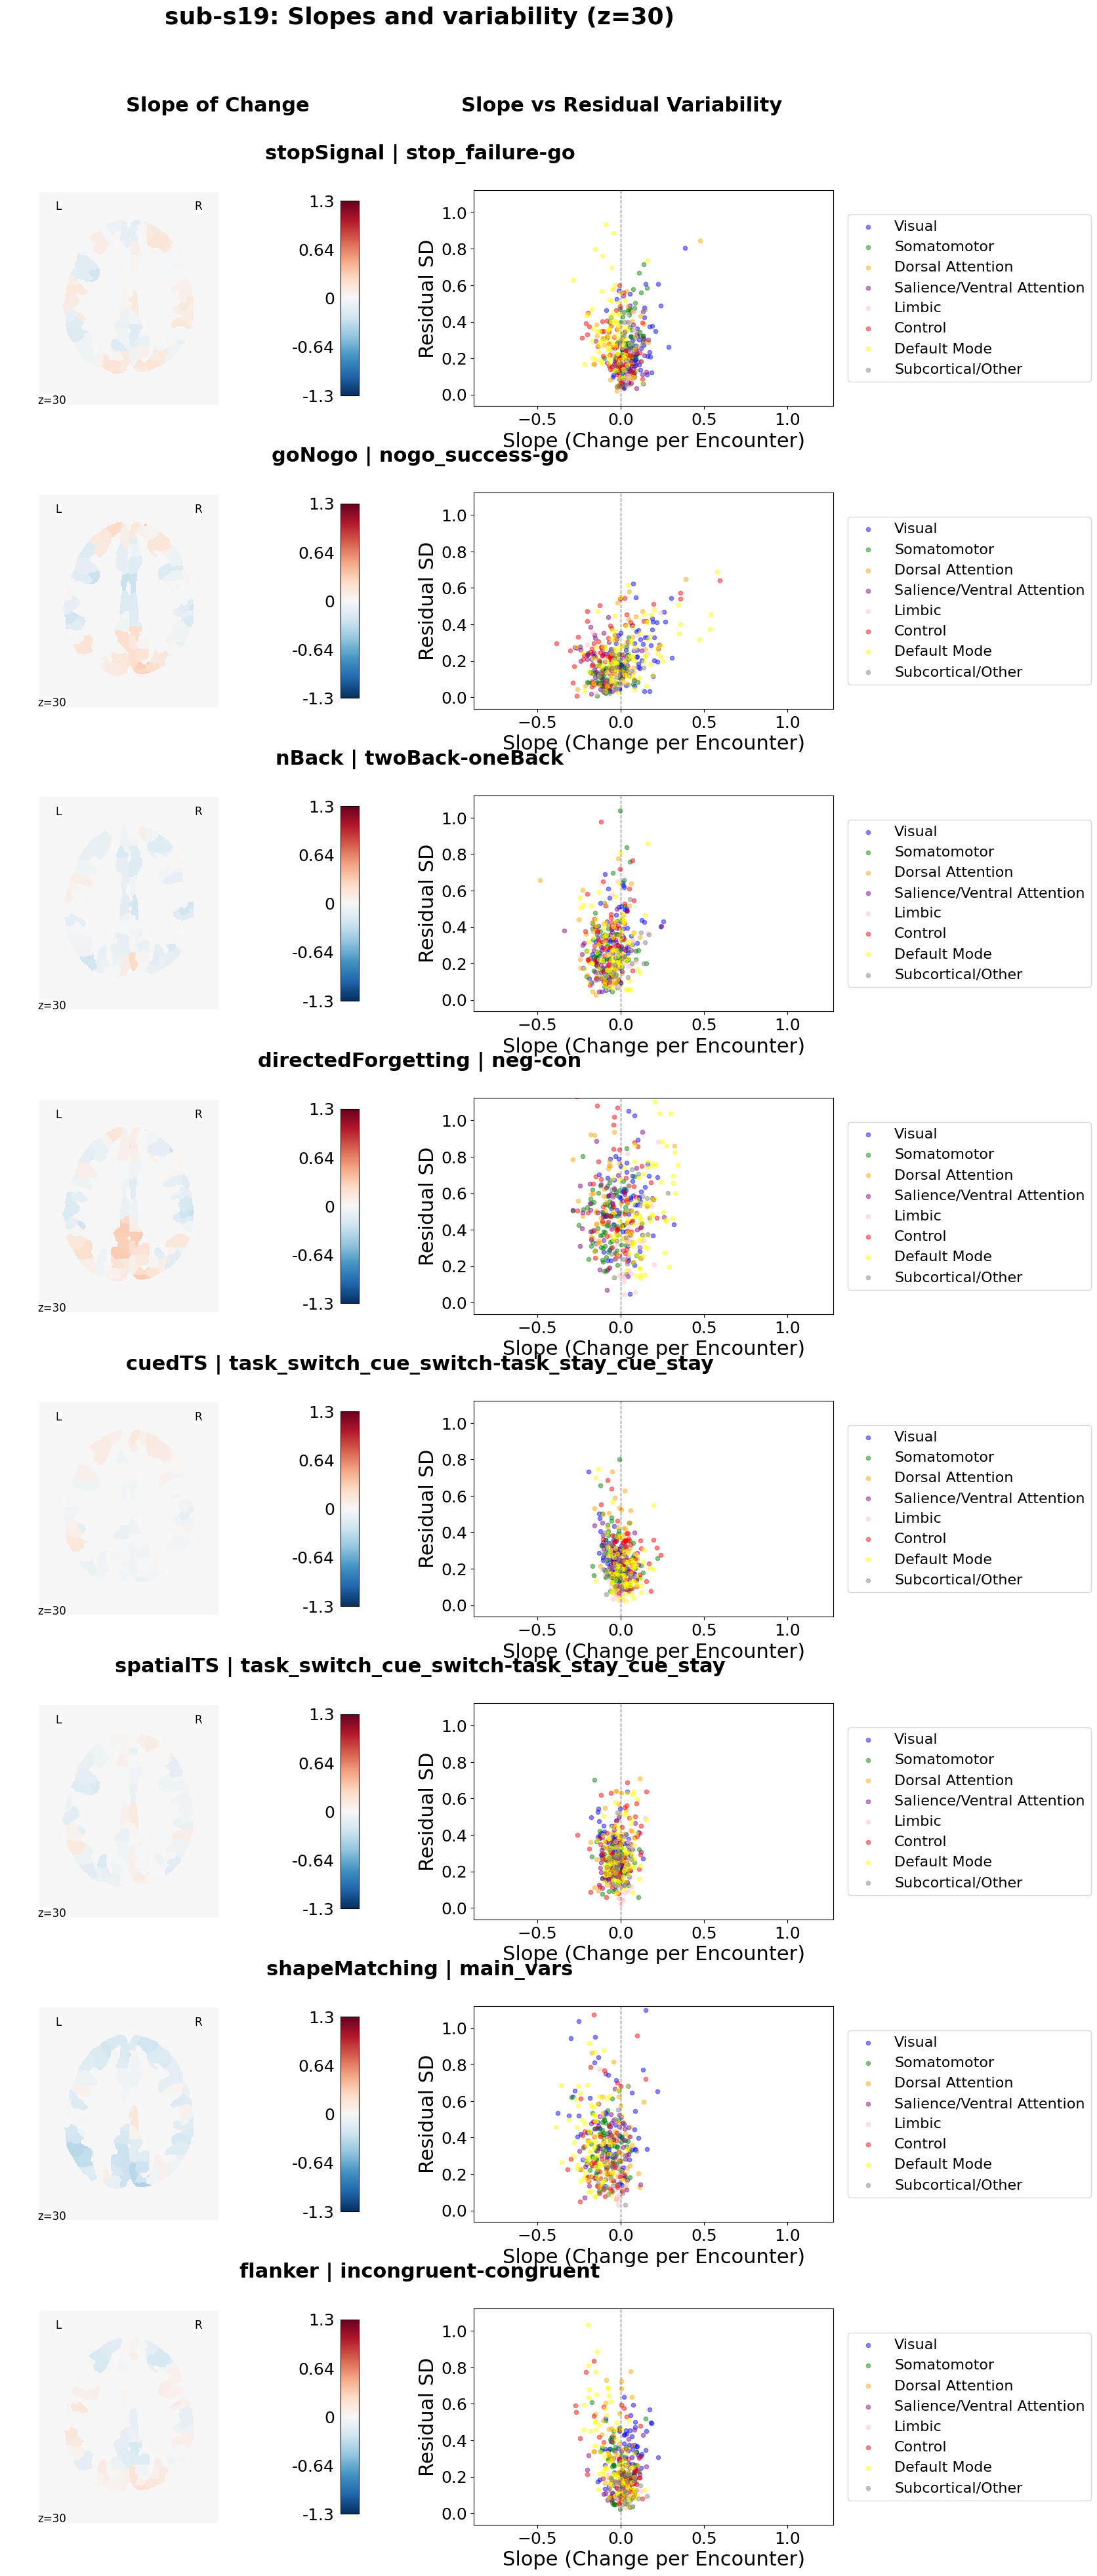

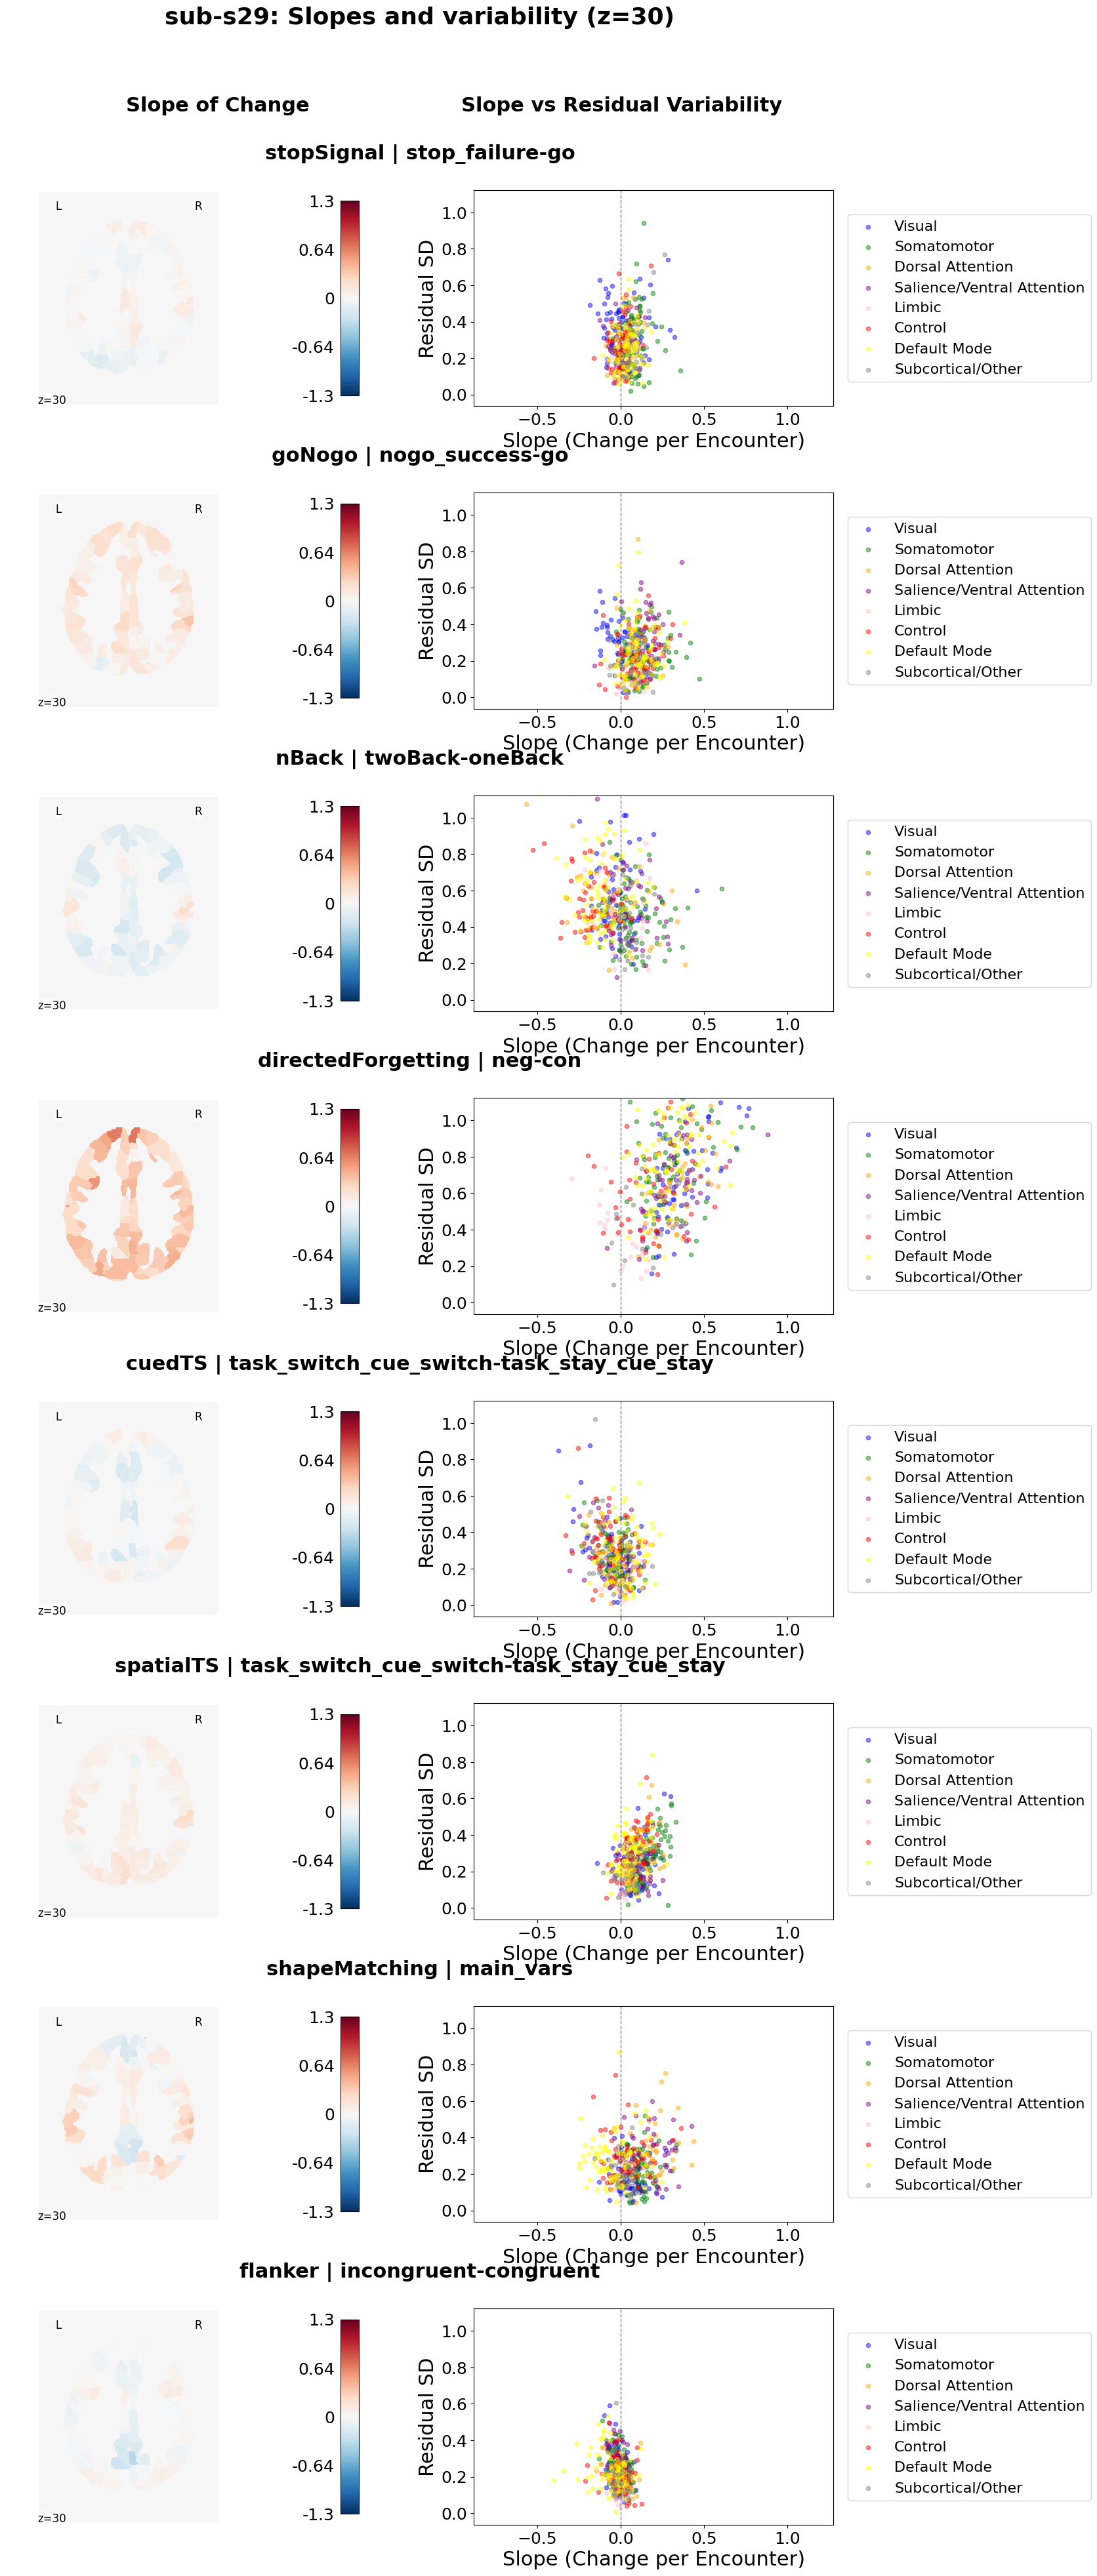

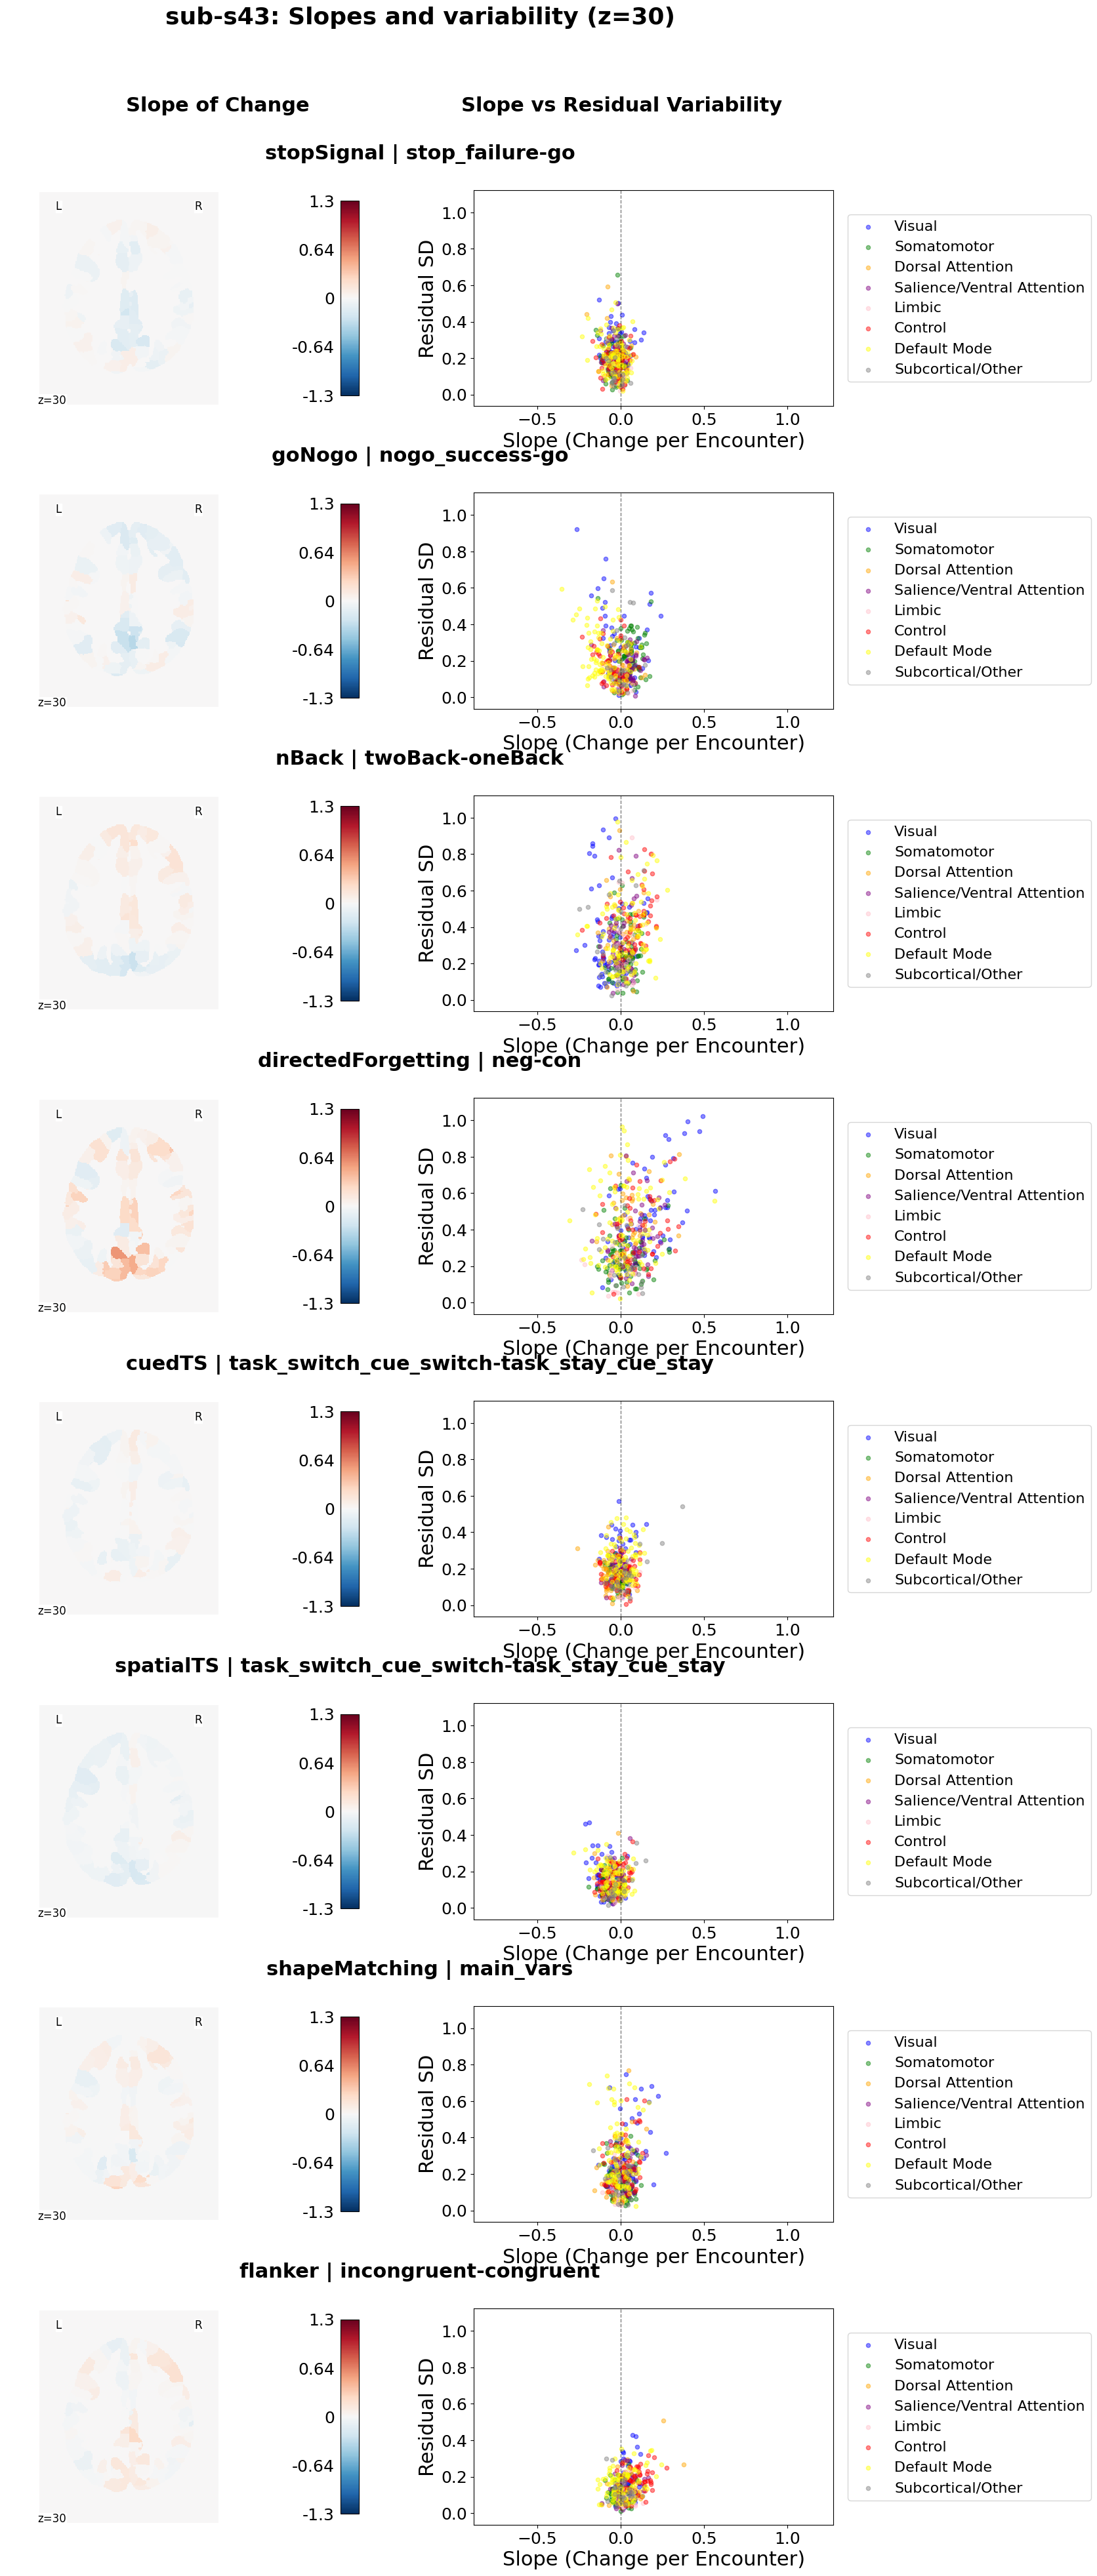

In [21]:
subject_ids = list(indiv_activations.keys())

for subj_id in subject_ids:
    save_name = f"{subj_id}_slopes_plot_0113.png"
    subj_activations = indiv_activations[subj_id]
    indiv_plot_comprehensive_summary(subj_id, subj_activations, indiv_parcel_traj_results[subj_id],
                                    tasks_to_plot, z_slice=30,
                                    x_min=x_min, x_max = x_max, y_min=y_min, y_max = y_max,
                                    threshold=None, save_path=save_name)